#### LICENSE
These notes are released under the 
"Creative Commons Attribution-ShareAlike 4.0 International" license. 
See the **human-readable version** [here](https://creativecommons.org/licenses/by-sa/4.0/)
and the **real thing** [here](https://creativecommons.org/licenses/by-sa/4.0/legalcode). 

## Ridge regression 

Variable selection methods like stepwise can be highly variable. To illustrate this
issue consider the following simple experiment. As in the previous lecture, 
we apply stepwise on 5 randomly selected folds of the data, and look at the
models selected in each of them.

In [1]:
airp <- read.table('rutgers-lib-30861_CSV-1.csv', header=TRUE, sep=',')
library(MASS)
k <- 5
n <- nrow(airp)
set.seed(123456)
ii <- sample( (1:n) %% k + 1 )
for(j in 1:k) {
  x0 <- airp[ii != j, ]
  null0 <- lm(MORT ~ 1, data=x0)
  full0 <- lm(MORT ~ ., data=x0) # needed for stepwise
  step.lm0 <- stepAIC(null0, scope=list(lower=null0, upper=full0), trace=FALSE)
  print(formula(step.lm0)[[3]])
}

NONW + EDUC + JANT + OVR65 + SO.
NONW + EDUC + PREC + SO. + JULT
NONW + EDUC + JANT + SO. + PREC
NONW + SO. + JANT + PREC + DENS
NONW + JANT + EDUC + DENS + POPN + JULT + PREC + OVR65


Although many variables appear in more than one model, only
 `NONW` and `SO.` are in all of them, and 
`JANT` and `PREC` in 4 out of the 5. 
There are also several that appear in only one
model (`HOUS`,
`WWDRK` and 
`POPN`).
<!-- `EDUC` 3 -->
<!-- `JULT` in 3,  -->
<!-- `DENS` in 2 -->
<!-- and  -->
This variability may in turn impact (negatively) the accuracy of the
resulting predictions. 

A different approach to dealing with potentially correlated explanatory
variables (with the goal of obtaining less variable / more accurate 
predictions) is to "regularize" the parameter estimates. In other words
we modify the optimization problem that defines the parameter 
estimators (in the case of linear regression fits we tweak 
the least squares problem) to limit their size (in fact restricting 
them to be in a bounded and possibly small subset of the parameter
space). 

The first proposal for a regularized / penalized estimator for 
linear regression models is Ridge Regression. 
We will use the function `glmnet` in package `glmnet` to
compute the Ridge Regression estimator. Note that this 
function implements a larger family of regularized estimators,
and in order to obtain a Ridge Regression estimator
we need to set the argument `alpha = 0` of `glmnet()`. 
<!-- We use Ridge Regression with the air pollution data to obtain a -->
<!-- more stable predictor. -->
We also specify a range of possible values of the penalty 
coefficient (below we use a grid of 50 values between 
exp(-3) and exp(10)).

In [2]:
library(glmnet)
y <- as.vector(airp$MORT)
xm <- as.matrix(airp[, -16])
lambdas <- exp( seq(-3, 10, length=50))
a <- glmnet(x=xm, y=y, lambda=rev(lambdas),
            family='gaussian', alpha=0)
# alpha = 0 - Ridge
# alpha = 1 - LASSO

Loading required package: Matrix

Loaded glmnet 4.1-6



The returned object contains the estimated regression coefficients for
each possible value of the regularization parameter. We can look at
them using the `plot` method for objects of class `glmnet` as 
follows:

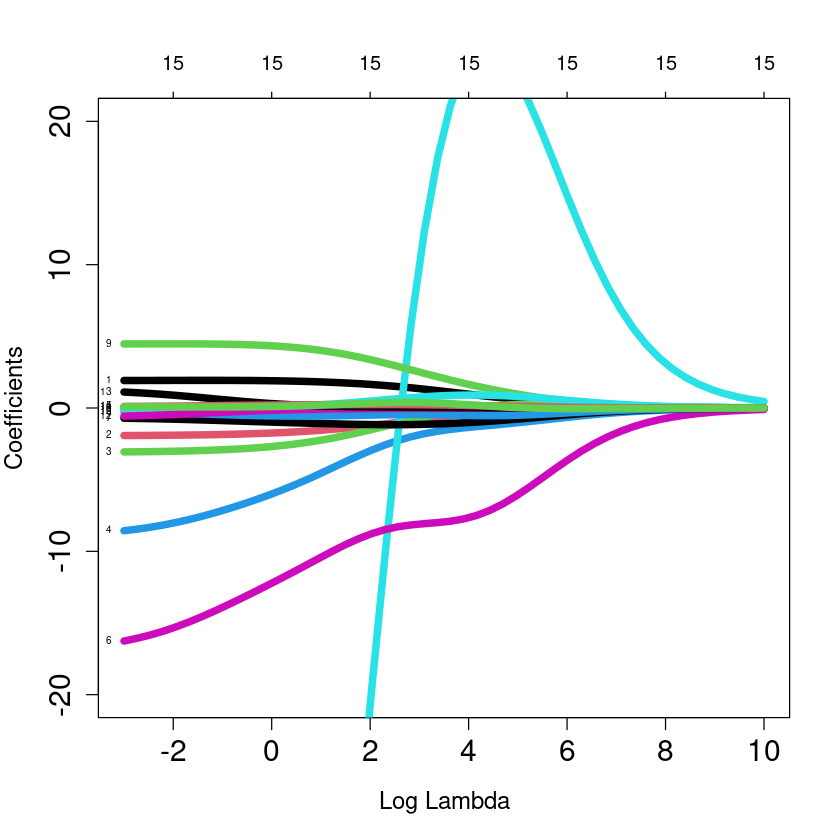

In [3]:
plot(a, xvar='lambda', label=TRUE, lwd=6, cex.axis=1.5, cex.lab=1.2, ylim=c(-20, 20))

### Selecting the level of regularization

Different values of the penalization parameter will typically yield estimators with
varying predictive accuracies. To select a good level of regularization we estimate
the MSPE of the estimator resulting from each value of the penalization parameter.
One way to do this is to run K-fold cross validation for each value of
the penalty. The `glmnet` package provides a built-in function to do this, 
and a `plot` method to display the results:

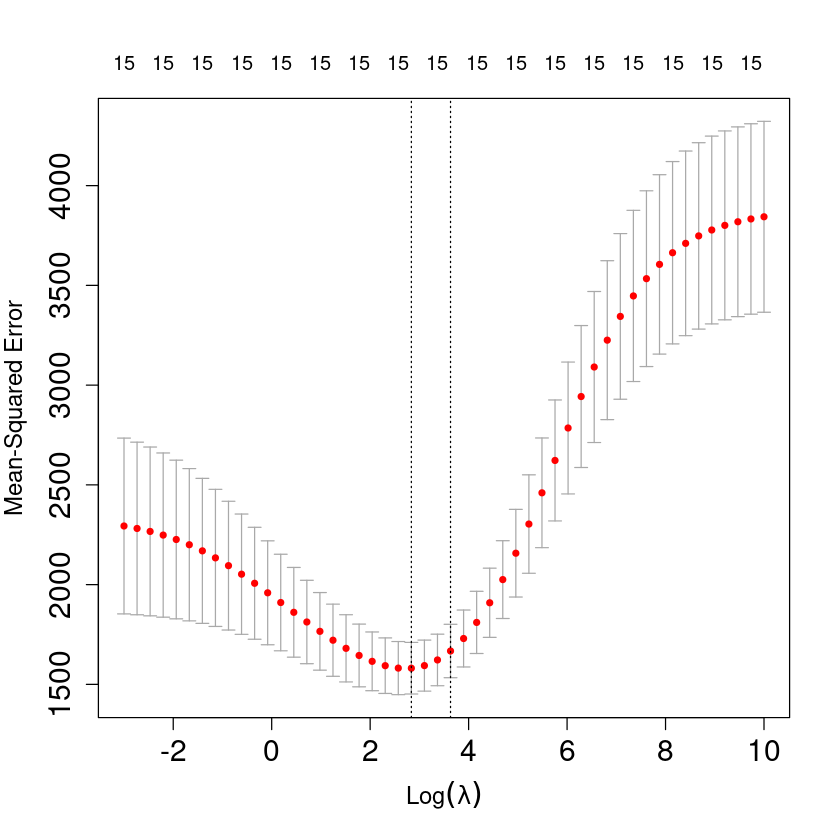

In [4]:
# run 5-fold CV
set.seed(123)
tmp <- cv.glmnet(x=xm, y=y, lambda=lambdas, nfolds=5, alpha=0, family='gaussian')
plot(tmp, lwd=6, cex.axis=1.5, cex.lab=1.2)

In the above plot the red dots are the estimated MSPE's for each value of the
penalty, and the vertical lines mark plus/minus one (estimated) standard deviations (for each
of those estimated MSPE's). The `plot` method will also mark the optimal value of
the regularization parameter, and also the largest one for which the estimated MSPE
is within 1-SD of the optimal. The latter is meant to provide a more regularized
estimator with estimated MSPE within the error-margin of our estimated minimum.

Note, however, that the above "analysis" is random (because of the intrinsic randomness of
K-fold CV). If we run it again, we will most likely get different results. In many cases, 
however, the results will be qualitatively similar. If we run 5-fold CV again for this
data get the following plot:

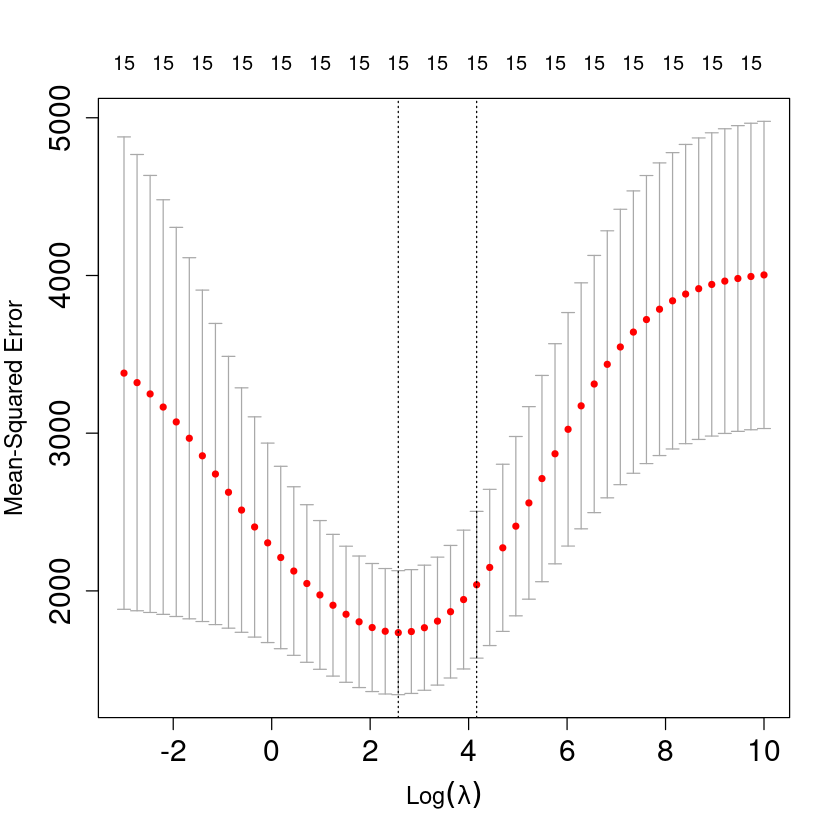

In [5]:
set.seed(23)
tmp <- cv.glmnet(x=xm, y=y, lambda=lambdas, nfolds=5, alpha=0, family='gaussian')
plot(tmp, lwd=6, cex.axis=1.5, cex.lab=1.2)

Note that both plots are similar, but not equal. It would be a good idea to repeat this
a few times and explore how much variability is involved. If one were interested
in selecting one value of the penalization parameter that was more stable than 
that obtained from a single 5-fold CV run, one could run it several times and
take the average of the estimated optimal values. For example:

In [6]:
set.seed(123)
op.la <- 0
for(j in 1:20) {
  tmp <- cv.glmnet(x=xm, y=y, lambda=lambdas, nfolds=5, alpha=0, family='gaussian')
  op.la <- op.la + tmp$lambda.min # tmp$lambda.1se
}
op.la <- op.la / 20
log(op.la)

[1] 2.437594

## An important limitation of Ridge Regression

Ridge Regression typically yields estimators with more accurate (less variable) 
predictions, specially when there is noticeable correlation among covariates. 
However, it is important to note that Ridge Regression does not select 
variables, and in that sense it does not "replace" methods like stepwise when
the interest is in using a smaller number of explanatory variables. Furthermore,
the interpretation of the Ridge Regression coefficient estimates is 
generally difficult. LASSO regression estimates were proposed to 
address these two issues (more stable predictions when correlated 
covariates are present **and** variable selection) simultaneously.